In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import tensorflow as tf
import numpy as np

In [2]:
class CNN(object):
    """

    """

    def __init__(self, p_keep_conv=1.0, p_keep_hidden=1.0,
                 batch_size=128, test_size=256, epoch_time=3):
        """
        Initialization
        :param batch_size
        :param test_size
        """
        self.w = self._init_weights([3, 3, 1, 32])  # 第一层卷积核大小为3x3,输入一张图,输出32个feature map
        self.w2 = self._init_weights([3, 3, 32, 64])  # 第二层卷积核大小为3x3,输入32个feature map,输出64个feature map
        self.w3 = self._init_weights([3, 3, 64, 128])  # 第三层卷积核大小为3x3,输入64个feature map,输出128个feature map
        self.w4 = self._init_weights([128 * 6 * 6, 1000])  # FC 128 * 4 * 4 inputs, 625 outputs
        self.w_o = self._init_weights([1000, 17])  # FC 625 inputs, 17 outputs (labels)
        self.batch_size = batch_size
        self.test_size = test_size
        self.sess = tf.Session()  # tensorflow session
        self.p_keep_conv = p_keep_conv
        self.p_keep_hidden = p_keep_hidden
        self.epoch_time = epoch_time

    def _init_weights(self, shape, name=None):
        """
        初始化参数
        :param shape:
        :param name:
        :return:
        """
        return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)

    def _cnn_main(self, X, p_keep_conv, p_keep_hidden):
        """
        :param X:
        :param p_keep_conv:
        :param p_keep_hidden:
        :return:
        """
        # 第一个卷积层:padding=SAME,保证输出的feature map与输入矩阵的大小相同
        l1a = tf.nn.relu(tf.nn.conv2d(X, self.w,  # l1a shape=(?, 28, 28, 32)
                                      strides=[1, 1, 1, 1], padding='SAME'))
        # max_pooling,窗口大小为2x2
        l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],  # l1 shape=(?, 14, 14, 32)
                            strides=[1, 2, 2, 1], padding='SAME')
        # dropout:每个神经元有p_keep_conv的概率以1/p_keep_conv的比例进行归一化,有(1-p_keep_conv)的概率置为0
        l1 = tf.nn.dropout(l1, p_keep_conv)

        # 第二个卷积层
        l2a = tf.nn.relu(tf.nn.conv2d(l1, self.w2,  # l2a shape=(?, 14, 14, 64)
                                      strides=[1, 1, 1, 1], padding='SAME'))
        l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],  # l2 shape=(?, 7, 7, 64)
                            strides=[1, 2, 2, 1], padding='SAME')
        l2 = tf.nn.dropout(l2, p_keep_conv)

        # 第三个卷积层
        l3a = tf.nn.relu(tf.nn.conv2d(l2, self.w3,  # l3a shape=(?, 7, 7, 128)
                                      strides=[1, 1, 1, 1], padding='SAME'))
        l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],  # l3 shape=(?, 4, 4, 128)
                            strides=[1, 2, 2, 1], padding='SAME')
        # 将所有的feature map合并成一个2048维向量
        l3 = tf.reshape(l3, [-1, self.w4.get_shape().as_list()[0]])  # reshape to (?, 2048)
        l3 = tf.nn.dropout(l3, p_keep_conv)
        # 后面两层为全连接层
        l4 = tf.nn.relu(tf.matmul(l3, self.w4))
        l4 = tf.nn.dropout(l4, p_keep_hidden)
        out = tf.matmul(l4, self.w_o)

        return out

    def _cnn(self, X, p_keep_conv, p_keep_hidden):
        """
        :param X:
        :param p_keep_conv:
        :param p_keep_hidden:
        :return:
        """
        # 第一个卷积层:padding=SAME,保证输出的feature map与输入矩阵的大小相同
        l1a = tf.nn.relu(tf.nn.conv2d(X, self.w,  # l1a shape=(?, 48, 48, 32)
                                      strides=[1, 1, 1, 1], padding='SAME'))
        # max_pooling,窗口大小为2x2
        l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],  # l1 shape=(?, 24, 24, 32)
                            strides=[1, 2, 2, 1], padding='SAME')
        # dropout:每个神经元有p_keep_conv的概率以1/p_keep_conv的比例进行归一化,有(1-p_keep_conv)的概率置为0
        l1 = tf.nn.dropout(l1, p_keep_conv)

        # 第二个卷积层
        l2a = tf.nn.relu(tf.nn.conv2d(l1, self.w2,  # l2a shape=(?, 24, 24, 64)
                                      strides=[1, 1, 1, 1], padding='SAME'))
        l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],  # l2 shape=(?, 12, 12, 64)
                            strides=[1, 2, 2, 1], padding='SAME')
        l2 = tf.nn.dropout(l2, p_keep_conv)

        # 第三个卷积层
        l3a = tf.nn.relu(tf.nn.conv2d(l2, self.w3,  # l3a shape=(?, 12, 12, 128)
                                      strides=[1, 1, 1, 1], padding='SAME'))
        l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],  # l3 shape=(?, 6, 6, 128)
                            strides=[1, 2, 2, 1], padding='SAME')
        # 将所有的feature map合并成一个2048维向量
        l3 = tf.reshape(l3, [-1, self.w4.get_shape().as_list()[0]])  # reshape to (?, 2048)
        l3 = tf.nn.dropout(l3, p_keep_conv)
        # 后面两层为全连接层
        l4 = tf.nn.relu(tf.matmul(l3, self.w4))
        l4 = tf.nn.dropout(l4, p_keep_hidden)
        out = tf.matmul(l4, self.w_o)

        return out

    def _alex_main(self, X, p_keep_conv, p_keep_hidden):
        """

        :param X:
        :param p_keep_conv:
        :param p_keep_hidden:
        :return:
        """

        kernel = tf.Variable(tf.truncated_normal([11, 11, 3, 96], stddev=1e-1))
        biases = tf.Variable(tf.constant(0.0, shape=[96]))
        conv1 = tf.nn.conv2d(X, kernel, [1, 4, 4, 1], padding='SAME')
        conv1 = tf.nn.relu(tf.nn.bias_add(conv1, biases))

        lrn1 = tf.nn.local_response_normalization(conv1, alpha=1e-4, beta=0.75, depth_radius=2, bias=2.0)

        pool1 = tf.nn.max_pool(lrn1, [1, 3, 3, 1], [1, 2, 2, 1], padding='VALID')

        kernel = tf.Variable(tf.truncated_normal([5, 5, 96, 256], stddev=1e-1))
        biases = tf.Variable(tf.constant(0.0, shape=[256]))
        conv2 = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
        conv2 = tf.nn.relu(tf.nn.bias_add(conv2, biases))

        lrn2 = tf.nn.local_response_normalization(conv2, alpha=1e-4, beta=0.75, depth_radius=2, bias=2.0)

        pool2 = tf.nn.max_pool(lrn2, [1, 3, 3, 1], [1, 2, 2, 1], padding='VALID')

        kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], stddev=1e-1))
        biases = tf.Variable(tf.constant(0.0, shape=[256]))
        conv3 = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
        conv3 = tf.nn.relu(tf.nn.bias_add(conv3, biases))

        kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 384], stddev=1e-1))
        biases = tf.Variable(tf.constant(0.0, shape=[384]))
        conv4 = tf.nn.conv2d(conv3, kernel, [1, 1, 1, 1], padding='SAME')
        conv4 = tf.nn.relu(tf.nn.bias_add(conv4, biases))

        kernel = tf.Variable(tf.truncated_normal([3, 3, 384, 256], stddev=1e-1))
        biases = tf.Variable(tf.constant(0.0, shape=[256]))
        conv5 = tf.nn.conv2d(conv4, kernel, [1, 1, 1, 1], padding='SAME')
        conv5 = tf.nn.relu(tf.nn.bias_add(conv5, biases))

        pool5 = tf.nn.max_pool(conv5, [1, 3, 3, 1], [1, 2, 2, 1], padding='VALID')

        input_shape = pool5.get_shape().as_list()
        new_shape = input_shape[1] * input_shape[2] * input_shape[3]
        weights = tf.Variable(tf.truncated_normal([new_shape, 4096], stddev=1e-1))
        biases = tf.Variable(tf.constant(0.0, shape=[4096]))
        fc6 = tf.matmul(tf.reshape(pool5, [-1, new_shape]), weights) + biases
        fc6 = tf.nn.relu(fc6)

        weights = tf.Variable(tf.truncated_normal([4096, 4096], stddev=1e-1))
        biases = tf.Variable(tf.constant(0.0, shape=[4096]))
        fc7 = tf.matmul(fc6, weights) + biases
        fc7 = tf.nn.relu(fc7)

        weights = tf.Variable(tf.truncated_normal([4096, 1000], stddev=1e-1))
        biases = tf.Variable(tf.constant(0.0, shape=[1000]))
        fc8 = tf.matmul(fc7, weights) + biases
        fc8 = tf.nn.softmax(fc8)

        return fc8

    def fit(self, train_x, train_y, test_x, test_y, extra_tx, extra_ty):
        """

        :param train_x:
        :param train_y:
        :param test_x:
        :param test_y:
        :return:
        """
        p_keep_conv = tf.placeholder("float")  # 卷积层的dropout概率
        p_keep_hidden = tf.placeholder("float")  # 全连接层的dropout概率
        X = tf.placeholder("float", [None, 28, 28, 1])
        Y = tf.placeholder("float", [None, 17])

        out = self._cnn_main(X, p_keep_conv, p_keep_hidden)

        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=out, labels=Y))  # 交叉熵目标函数

        train_op = tf.train.AdamOptimizer(0.001, 0.9) \
            .minimize(cost)  # RMSPro算法最小化目标函数

        predict_op = tf.argmax(out, 1)  # 返回每个样本的预测结果

        init = tf.global_variables_initializer()

        self.sess.run(init)
        for i in range(self.epoch_time):
            training_batch = zip(range(0, len(train_x), self.batch_size),
                                 range(self.batch_size, len(train_x) + 1, self.batch_size))
            for start, end in training_batch:
                self.sess.run(
                    train_op,
                    feed_dict={X: np.vstack([train_x[start:end], extra_tx]),
                               Y: np.vstack([train_y[start:end], extra_ty]),
                               p_keep_conv: self.p_keep_conv,
                               p_keep_hidden: self.p_keep_hidden})
                # self.sess.run(
                #     train_op,
                #     feed_dict={X: extra_tx,
                #                Y: extra_ty,
                #                p_keep_conv: self.p_keep_conv,
                #                p_keep_hidden: self.p_keep_hidden})

            test_indices = np.arange(len(test_x))
            np.random.shuffle(test_indices)
            test_indices = test_indices[0: self.test_size]

            print('epoch %s' % i, np.mean(np.argmax(test_y[test_indices], axis=1) ==
                                          self.sess.run(
                                              predict_op, feed_dict={
                                                  X: test_x[test_indices],
                                                  p_keep_conv: 1.0,
                                                  p_keep_hidden: 1.0})))

    def fit_new(self, train_x, train_y, test_x, test_y):
        """
        :return:
        """
        p_keep_conv = tf.placeholder("float")  # 卷积层的dropout概率
        p_keep_hidden = tf.placeholder("float")  # 全连接层的dropout概率
        X = tf.placeholder("float", [None, 48, 48, 1])
        Y = tf.placeholder("float", [None, 17])

        out = self._cnn(X, p_keep_conv, p_keep_hidden)

        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=out, labels=Y))  # 交叉熵目标函数

        train_op = tf.train.AdamOptimizer(0.001, 0.9) \
            .minimize(cost)  # RMSPro算法最小化目标函数

        predict_op = tf.argmax(out, 1)  # 返回每个样本的预测结果

        init = tf.global_variables_initializer()

        self.sess.run(init)
        for i in range(self.epoch_time):
            training_batch = zip(range(0, len(train_x), self.batch_size),
                                 range(self.batch_size, len(train_x) + 1, self.batch_size))
            for start, end in training_batch:
                # print(train_x[start:end].shape, train_y[start:end].shape)
                self.sess.run(
                    train_op,
                    feed_dict={X: train_x[start:end],
                               Y: train_y[start:end],
                               p_keep_conv: self.p_keep_conv,
                               p_keep_hidden: self.p_keep_hidden})

            test_indices = np.arange(len(test_x))
            np.random.shuffle(test_indices)
            test_indices = test_indices[0: self.test_size]

            print('epoch %s' % i, np.mean(np.argmax(test_y[test_indices], axis=1) ==
                                          self.sess.run(
                                              predict_op, feed_dict={
                                                  X: test_x[test_indices],
                                                  p_keep_conv: 1.0,
                                                  p_keep_hidden: 1.0})))

    def save(self, model_name):
        """

        :param model_name:
        :return:
        """
        saver = tf.train.Saver()
        saver.save(self.sess, model_name)
        print("save model:{0} Finished".format(model_name))

    def predict(self, img):
        """

        :param img:
        :return:
        """
        p_keep_conv = tf.placeholder("float")  # 卷积层的dropout概率
        p_keep_hidden = tf.placeholder("float")  # 全连接层的dropout概率
        X = tf.placeholder("float", [None, 28, 28, 1])

        out = self._cnn_main(X, p_keep_conv, p_keep_hidden)
        predict_op = tf.argmax(out, 1)  # 返回每个样本的预测结果

        predict = self.sess.run(
            predict_op, feed_dict={
                X: img.reshape(-1, 28, 28, 1),
                p_keep_conv: 1.0,
                p_keep_hidden: 1.0})

        return predict

    def predict_new(self, img):
        """

        :param img:
        :return:
        """
        p_keep_conv = tf.placeholder("float")  # 卷积层的dropout概率
        p_keep_hidden = tf.placeholder("float")  # 全连接层的dropout概率
        X = tf.placeholder("float", [None, 48, 48, 1])

        out = self._cnn_main(X, p_keep_conv, p_keep_hidden)
        predict_op = tf.argmax(out, 1)  # 返回每个样本的预测结果

        predict = self.sess.run(
            predict_op, feed_dict={
                X: img.reshape(-1, 48, 48, 1),
                p_keep_conv: 1.0,
                p_keep_hidden: 1.0})

        return predict

    def load_session(self, model_name):
        """

        :param model_name:
        :return:
        """
        # init = tf.global_variables_initializer()
        # self.sess.run(init)
        saver = tf.train.Saver()
        saver.restore(self.sess, model_name)

In [5]:
cnn = CNN()

cnn.load_session('../new_model/Test_CNN_Model.ckpt')

INFO:tensorflow:Restoring parameters from ../new_model/Test_CNN_Model.ckpt


In [6]:
tf.all_variables()

Instructions for updating:
Please use tf.global_variables instead.


[<tf.Variable 'Variable:0' shape=(3, 3, 1, 32) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(4608, 1000) dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=(1000, 17) dtype=float32_ref>]

In [3]:
def get_non0_index_scope(l):
    """

    :param l:
    :return:
    """
    if l[0]:
        start = 0
    else:
        start = l.index(True)
    l.reverse()
    if l[0]:
        end = 0
    else:
        end = l.index(True)
    end = len(l) - end
    return start, end


def get_min_content_area(img):
    """

    :param img:
    :return:
    """
    col_proj = (np.sum(img, axis=0) != 0).tolist()
    row_proj = (np.sum(img, axis=1) != 0).tolist()
    col_start, col_end = get_non0_index_scope(col_proj)
    row_start, row_end = get_non0_index_scope(row_proj)

    return row_start, row_end, col_start, col_end


def get_resize_padding_img(img, size=None, padding=None):
    """

    :param img:
    :param size:
    :param padding:
    :return:
    """
    if size and padding:
        sub_img = cv2.resize(img, size)
        sub_img = np.pad(sub_img, padding, mode='constant')
        sub_img = np.pad(sub_img, ((3,), (3,)), mode='constant')
    else:
        sub_img = cv2.resize(img, (28, 28))
    return sub_img

In [69]:
def preprocessing(img):
    row_start, row_end, col_start, col_end = get_min_content_area(img)
    sub_img = img[row_start: row_end, col_start: col_end]
    
    if col_end - col_start < row_end - row_start:  # 铅直边较长
        change_rate = (row_end - row_start - 42) / float((row_end - row_start))
        changed_width = int((col_end - col_start) * (1 - change_rate))

        if changed_width % 2 == 1:
            changed_width += 1
        if changed_width == 0:
            changed_width = 2
        pad = (42 - changed_width) / 2
        padding = ((0,), (int(pad),))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_width, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(changed_width, 42), padding=padding)

    else:  # 水平边较长
        # change_rate = (x1 - x0 - 42) / float((x1 - x0))
        # changed_height = int((y1 - y0) * (1 - change_rate))

        change_rate = (col_end - col_start - 42) / float((col_end - col_start))
        changed_height = int((row_end - row_start) * (1 - change_rate))

        if changed_height % 2 == 1:
            changed_height += 1
        if changed_height == 0:
            changed_height = 2
        pad = (42 - changed_height) / 2
        padding = ((int(pad),), (0,))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_height, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(42, changed_height), padding=padding)

    return sub_img

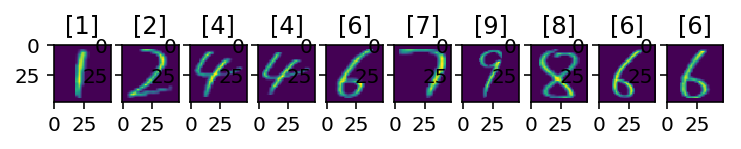

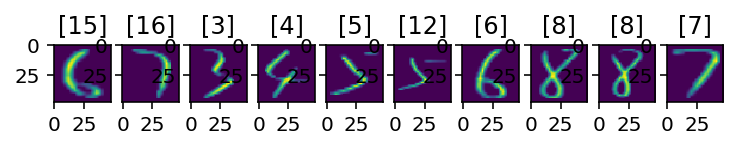

In [84]:
for j in range(0, 6):
    if j > 3:
        for i in range(1, 11):
            img = cv2.imread('testimg/%s/%s.jpg' % (j, i), cv2.IMREAD_GRAYSCALE)
            img = (255 - img) / 255.0
            img[img < 0.16] = 0.0

            img = cv2.resize(img, (48, 48))

            sub_img = preprocessing(img)
        
            plt.subplot(6, 10, i + j * 10)
            plt.imshow(sub_img)
            plt.title(cnn.predict_new(sub_img))
    plt.show()

In [86]:
sub_img.shape

(48, 48)